<a href="https://colab.research.google.com/github/brotheramin/MachineLearning/blob/main/MovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

M**ovie Recommendations**

Recommendations are a common machine learning task widely used by many leading companies, such as Netflix, Amazon, and YouTube. If you have used any of these online services, you are familiar with recommendations that are often prefixed with "You might also like.." or "Recommended items other customers buy...".

There are many ways to generate recommendations. It could be done based on simple criteria, such as movie genre, e.g. comedies or action adventure. More sophisticated recommendations might consider many more factors, such as the director, when the movie was produced and so on.

In this example, we will use a common, straightforward method known as [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering). This method is based on idea that many customers have similar likes and dislikes. It also considers similarities between products. It's a simple, yet effective technique that depends only user preferences, such as product ratings. If you have a sufficiently large dataset of ratings from your customers, then this approach is a good place to start.

In [1]:
%tensorflow_version 1.x

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


**Load data**

In this example, we will make movie recommendations given about 100,000 samples from roughly 10,000 customers or users.

The data set is freely available on the [MovieLens website](https://grouplens.org/datasets/movielens/).

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2022-07-30 08:41:49--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2022-07-30 08:41:49 (7.69 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [4]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [5]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**Join Ratings with Movies**

The ratings don't contain movie titles, so let's join or merge these two sets for convenience.

In [7]:
ratings = ratings.merge(movies, on='movieId').drop(['genres','timestamp'],axis=1)
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


**Generate Sequential Identifiers**

userId and movieId are not sequential, which causes problems for our model. To compensate, we can use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html/) class from [scikit-learn](https://scikit-learn.org/stable/) to generate sequential identifiers for users and movies. The original identifiers are still available, so we can always join back to the original data set if needed

In [8]:
user_enc = LabelEncoder()
ratings['userSeq'] = user_enc.fit_transform(ratings['userId'].values)

item_enc = LabelEncoder()
ratings['movieSeq'] = item_enc.fit_transform(ratings['movieId'].values)

ratings.head()

,userId,movieId,rating,title,userSeq,movieSeq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0


**Train/Test Split**

This case is a bit unusual because we need ratings for every movie from every user to train an accurate model. If we used a traditional split, some movies might be left out, which will cause problems during prediction.

For this reason, we will use all of the data for training and a subset for model validation only.

In [9]:
train_unused, test = train_test_split(ratings, test_size=0.20, random_state=0)

# All data is used for training
train = ratings

numUsers = len(train.userSeq.unique())
numMovies = len(train.movieSeq.unique())
print((numUsers, numMovies))
print((len(train), len(test)))

(610, 9724)
(100836, 20168)


**Recommendation Model**

Collaborative filtering tries to minimize the error between a predicted value and ground truth. This is similar to many supervised machine learning problems. The model learns a set of features that similar movies share. The number of features could be as simple as the genre or more complex. The numFeatures variable below is a hyperparameter that can be tuned to optimize performance.

This model uses the [Keras functional API](https://keras.io/guides/functional_api/) rather than adding layers to a Sequential model. This is necessary because we have two sets of inputs, userSeq and movieSeq.

In [10]:
numFeatures = 50
dropout = 0.0

user_input = Input(shape=(1,))
user_emb = Embedding(numUsers, numFeatures)(user_input)
flat_user = Flatten()(user_emb)
user_dropout = Dropout(dropout)(flat_user)

movie_input = Input(shape=(1,))
movie_emb = Embedding(numMovies, numFeatures)(movie_input)
flat_movie = Flatten()(movie_emb)
movie_dropout = Dropout(dropout)(flat_movie)

dotProduct = Dot(axes=1)([user_dropout, movie_dropout])

user_bias = Embedding(numUsers, 1)(user_input)
movie_bias = Embedding(numMovies, 1)(movie_input)
sum = Add()([dotProduct, user_bias, movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model = Model([user_input, movie_input], output)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
___________

**Model Training**


Train on 100836 samples, validate on 20168 samples
Epoch 1/10
100836/100836 [==============================] - 32s 313us/step - loss: 6.2141 - val_loss: 1.4650
Epoch 2/10
100836/100836 [==============================] - 31s 306us/step - loss: 1.1515 - val_loss: 0.8080
Epoch 3/10
100836/100836 [==============================] - 27s 264us/step - loss: 0.8154 - val_loss: 0.6486
Epoch 4/10
100836/100836 [==============================] - 30s 298us/step - loss: 0.6791 - val_loss: 0.5445
Epoch 5/10
100836/100836 [==============================] - 31s 310us/step - loss: 0.5718 - val_loss: 0.4555
Epoch 6/10
100836/100836 [==============================] - 33s 329us/step - loss: 0.4784 - val_loss: 0.3783
Epoch 7/10
100836/100836 [==============================] - 45s 442us/step - loss: 0.3972 - val_loss: 0.3057
Epoch 8/10
100836/100836 [==============================] - 27s 265us/step - loss: 0.3267 - val_loss: 0.2492
Epoch 9/10
100836/100836 [==============================] - 27s 265us/step -

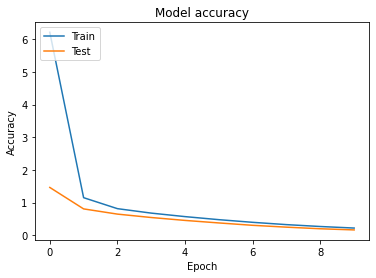

In [11]:
model.compile(loss='mean_squared_error', optimizer=Adam())
history = model.fit([train.userSeq, train.movieSeq], train.rating,
                    batch_size=32, epochs=10, verbose=1,
                    validation_data=([test.userSeq, test.movieSeq], test.rating))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Notice the validation loss is slightly lower than the training loss. If the model was overfitting, then the opposite would be true, so this is a peculiar case.

There are a few reasons this can happen:

1- Keras artifact explained the [Keras FAQ](https://keras.io/getting_started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss). Keras computes training loss as the average during training time, which can change quite a bit during one epoch. Validation is computed at the end of an epoch when the model loss is probably lower.

2- The test set is not not representative of the training set. In some cases, the test set might be easier to predict than the training set. This could happen if a very small test set is used.

**Make Predictions**

We can make predictions for a given user by creating a numpy array of all movies and a numpy array of the same dimension filled with just the one user we are interested in. The model will predict ratings for the specified user given all movies in the full data set.

We can then sort the data set by predicted rating descending to get the best recommendations first.

In [12]:
# The user for whom we want to make recommendations
userNumber = 0

uniqueMovies = ratings.drop_duplicates(subset=['movieSeq'])

movie_vector = uniqueMovies.movieSeq.values
user_vector = np.ones((len(uniqueMovies),)) * userNumber
predictions = model.predict([user_vector, movie_vector])
pSeries = pd.Series([a[0] for a in predictions])
predictedDF = uniqueMovies.copy()
predictedDF['Predictions'] = pSeries

predictedDF.sort_values(by='Predictions', ascending=False).head(10)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions
4121,1,592,4.0,Batman (1989),0,509,6.395571
6127,1,1080,5.0,Monty Python's Life of Brian (1979),0,819,6.050427
4992,1,661,5.0,James and the Giant Peach (1996),0,551,5.786843
2755,1,362,5.0,"Jungle Book, The (1994)",0,320,5.561468
5770,1,1025,5.0,"Sword in the Stone, The (1963)",0,783,5.459544
776,1,70,3.0,From Dusk Till Dawn (1996),0,62,5.308881
1135,1,157,5.0,Canadian Bacon (1995),0,130,5.263272
4830,1,648,3.0,Mission: Impossible (1996),0,546,5.245226
267,1,6,4.0,Heat (1995),0,5,5.215852
6457,1,1097,5.0,E.T. the Extra-Terrestrial (1982),0,835,5.178910


**Error Analysis**

Let's look at some movies where the ground truth did not compare well with predictions.

In [13]:
oneUser = predictedDF[predictedDF.userSeq == userNumber].copy()
oneUser['Error'] = (oneUser.rating - oneUser.Predictions)**2
oneUser.sort_values(by='Error', ascending=False).head(5)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions,Error
4649,1,608,5.0,Fargo (1996),0,520,1.337936,13.410712
6216,1,1089,5.0,Reservoir Dogs (1992),0,827,1.355606,13.281606
6641,1,1136,5.0,Monty Python and the Holy Grail (1975),0,862,1.598527,11.570021
9305,1,1396,3.0,Sneakers (1992),0,1075,-0.368106,11.344138
8450,1,1256,5.0,Duck Soup (1933),0,954,1.780587,10.364620


In [14]:
ratings[ratings.movieSeq == 520].sort_values(by='rating', ascending=True)

,userId,movieId,rating,title,userSeq,movieSeq
4827,607,608,2.0,Fargo (1996),606,520
4672,78,608,2.0,Fargo (1996),77,520
4810,546,608,2.0,Fargo (1996),545,520
4669,71,608,2.0,Fargo (1996),70,520
4812,554,608,2.0,Fargo (1996),553,520
...,...,...,...,...,...,...
4725,251,608,5.0,Fargo (1996),250,520
4718,221,608,5.0,Fargo (1996),220,520
4717,220,608,5.0,Fargo (1996),219,520
4754,324,608,5.0,Fargo (1996),323,520
